# Toxic Comment Classification

## Introduction

This is the project for CS584 Machine Learning. We use the dataset from Kaggle to do the classification of toxic comments. The dataset can be found [here](https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge).

## Team Member

- Xiao Wang
- ChengXin Zeng
- Ayden Franklin

## Dataset Description

The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Our goal is to build a model that’s capable of detecting different types of toxicity. The dataset is a large number of comments from Wikipedia’s talk page edits which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

## File Description

**train.csv** - the training set, contains comments with their binary labels.  
**test.csv** - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.  
**sample_submission.csv** - a sample submission file in the correct format.  
**test_labels.csv** - labels for the test data; value of -1 indicates it was not used for scoring.

# Process Introduction

## Data Preprocessing

This project is an NLP task, so visualization of the data is very important. In order to understand this dataset in depth, we analyzed and visualized the dataset using a variety of techniques, including data label distribution, text length distribution, correlation matrix heatmap, word cloud, and so on. Then, we normalize and tokenize the text to get the processed word list. We use TF-IDF for vectorization and finally get the feature matrix for model training.

## Basic Model

## Boosting Model

# Model Implementation and Evaluation

## Data Preprocessing

### Load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Add nltk_data path
nltk.data.path.append('./nltk_data/')

# Download nltk data and save to ./nltk_data/ folder
nltk.download('punkt', download_dir='./nltk_data/')
nltk.download('stopwords', download_dir='./nltk_data/')
nltk.download('wordnet', download_dir='./nltk_data/')
sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to ./nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ./nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read the dataset
train = pd.read_csv('./archive/train.csv')
test = pd.read_csv('./archive/test.csv')
test_labels = pd.read_csv('./archive/test_labels.csv')
sample_submission = pd.read_csv('./archive/sample_submission.csv')
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [4]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [5]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
train.shape, test.shape, test_labels.shape, sample_submission.shape

((159571, 8), (153164, 2), (153164, 7), (153164, 7))

In [7]:
# check the missing values
missing_values = train.isnull().sum()
missing_values

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

It is clear that there are no missing values in the dataset.

### Data Analysis and Visualization

In [8]:
# count the number of each label
labels = train.columns[2:]
label_counts = train[labels].sum().sort_values(ascending=False)
label_counts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

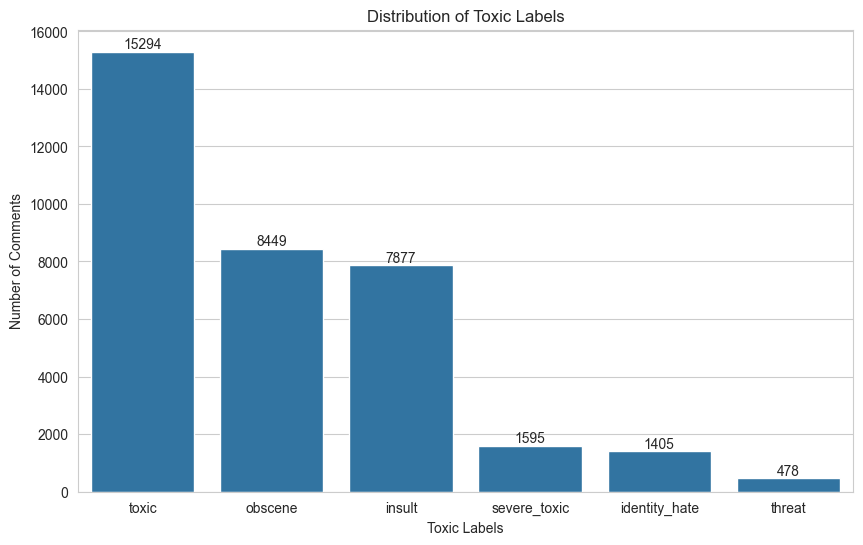

In [9]:
# plot the distribution of each label
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values)
for index, value in enumerate(label_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Distribution of Toxic Labels')
plt.xlabel('Toxic Labels')
plt.ylabel('Number of Comments')
plt.show()

We can observe that the toxic labels are highly imbalanced. In toxic comments, the comments with label "toxic" are the most common, followed by "obscene", "insult". The number of comments with label "severe_toxic", "identity_hate" and "threat" are rare. It means that we may encounter the problem of overfitting when training the model.

In [10]:
# count the number of comments with multiple labels
row_sum = train.iloc[:, 2:].sum(axis=1)
multi_label_counts = row_sum.value_counts()
multi_label_counts

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

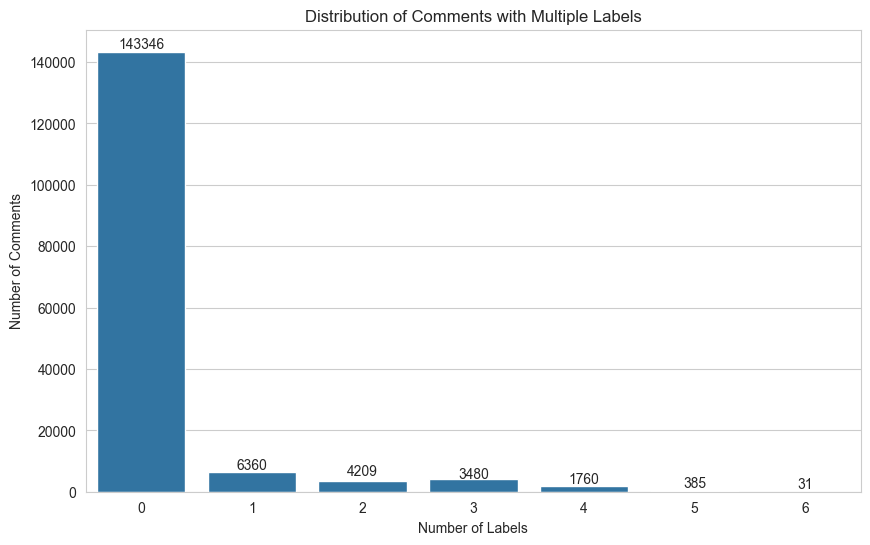

In [11]:
# plot the distribution of comments with multiple labels
plt.figure(figsize=(10,6))
sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values)
for index, value in enumerate(multi_label_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Distribution of Comments with Multiple Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Comments')
plt.show()

The diagram shows that most comments in train dataset are not toxic. In toxic comments, several comments have multiple labels. Some of them even have all six labels. We need to build a multi-label classification model to solve this problem.

In [12]:
# calculate the correlation matrix
corr = train.iloc[:,2:].corr()
corr

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


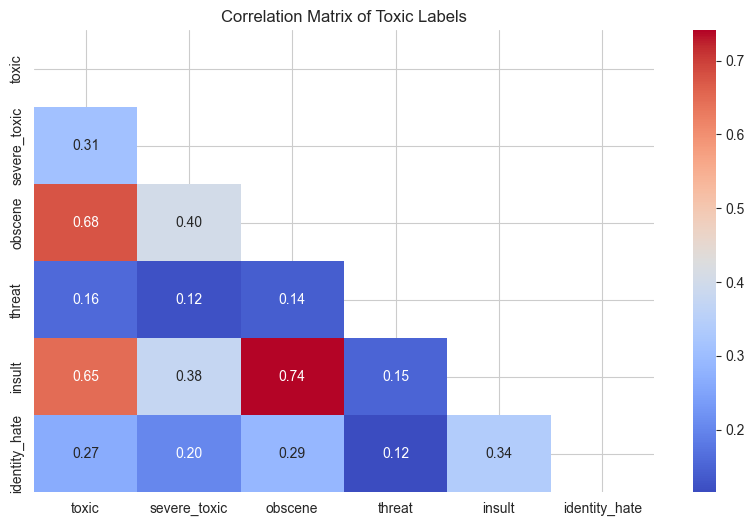

In [13]:
# plot the correlation matrix as a heatmap
plt.figure(figsize=(10,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Toxic Labels')
plt.show()

The correlation matrix shows the correlation between the different labels of toxic comments. As we can see from the heatmap, there is a strong correlation between some labels, such as "toxic" and "obscene", "toxic" and "insult", "obscene" and "insult". It means that the comments with these labels are highly related. This is helpful in building a multi-label classification model.

In [14]:
# calculate the length of each comment
train['comment_length'] = train['comment_text'].apply(len)
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [15]:
train['comment_length'].describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

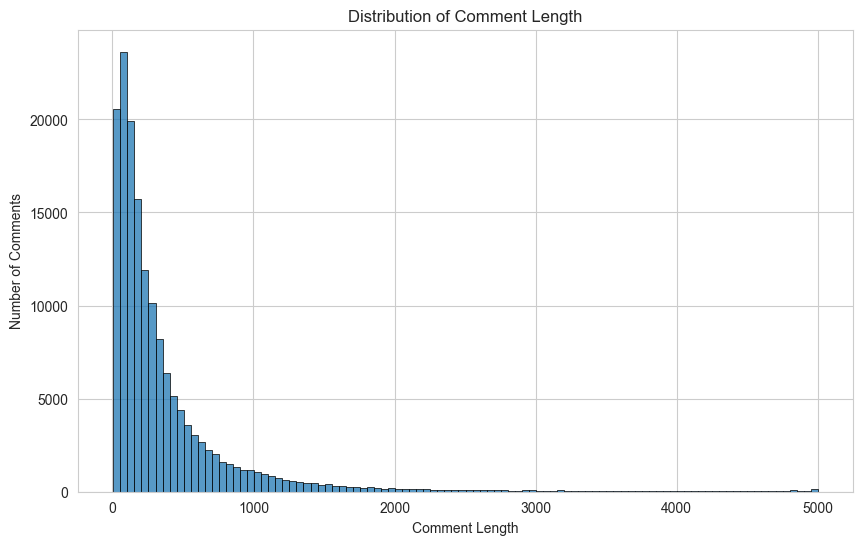

In [16]:
# plot the distribution of comment length
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='comment_length', bins=100, edgecolor='black')
plt.title('Distribution of Comment Length')
plt.ylabel('Number of Comments')
plt.xlabel('Comment Length')
plt.show()

In [17]:
# show the comment length > 4900
train[train['comment_length'] > 4900].sort_values(by='comment_length', ascending=False)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
158970,f6883b0b85b0dbd7,Hi Wikipedia!!Hi Wikipedia!!Hi Wikipedia!!Hi W...,0,0,0,0,0,0,5000
63392,a99aff4a8428dfb2,leari CAN STILL POST WITH THIS COMPUTER...I SA...,1,1,1,0,1,0,5000
27148,47d24c7955d1cc09,DAMN YOU U CUNT DAMN YOU U CUNT DAMN YOU U CUN...,1,1,1,0,1,0,5000
28855,4c7963eaf9697d35,JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST...,1,1,0,1,0,0,5000
34422,5bed308adc44efcf,YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...,1,1,1,0,1,0,5000
...,...,...,...,...,...,...,...,...,...
140845,f1b191be6eef2279,"""\n\n(2) The Quackbuster manipulation of Wiki...",0,0,0,0,0,0,4904
121852,8be68fd70df96705,Questions over status\n\nAs already mentioned ...,0,0,0,0,0,0,4904
143903,046f6f7cd1bff5e7,""" For example, a prior discussion: The whole s...",0,0,0,0,0,0,4903
99222,12c0565fb96caa5a,"""\n\nOkay, thanks, that's clear, I will action...",0,0,0,0,0,0,4902


By analyzing the distribution of comment length, we can find that most comments have a length less than 500 characters. But there are also a few comments have very long length. Given the differences in the length of comments, we may need to remove extremely long comments to improve the performance of our model. And looking at the data, a lot of the extremely long comments are meaningless, deleting them may be beneficial to the model.

In [18]:
# drop the comments with length > 4900
train.drop(train[train['comment_length'] > 4900].index, inplace=True)
train.shape

(159373, 9)

In [19]:
# drop the column "comment_length"
train.drop('comment_length', axis=1, inplace=True)
train.shape

(159373, 8)

In [41]:
# generate a wordcloud for a given data
def generate_wordcloud(data):
    text = " ".join(comment for comment in data.comment_text)
    wordcloud = WordCloud(stopwords=STOPWORDS, width=1000, height=600, background_color='white').generate(text)
    return wordcloud

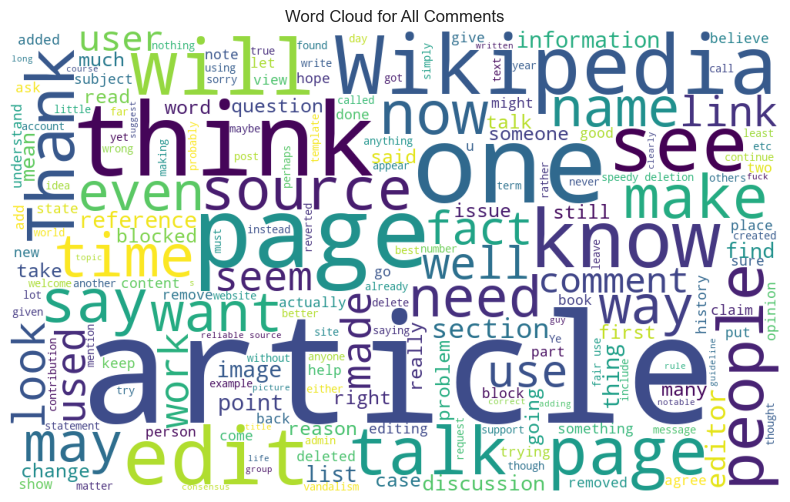

In [42]:
# generate a wordcloud for all comments
wordcloud = generate_wordcloud(train)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud for All Comments')
plt.show()

The wordcloud shows the most common words in comments. Since the dataset from Wikipedia’s talk page and most of the comments are non-toxic, the most common words are Wikipedia, page, article, edit, etc.

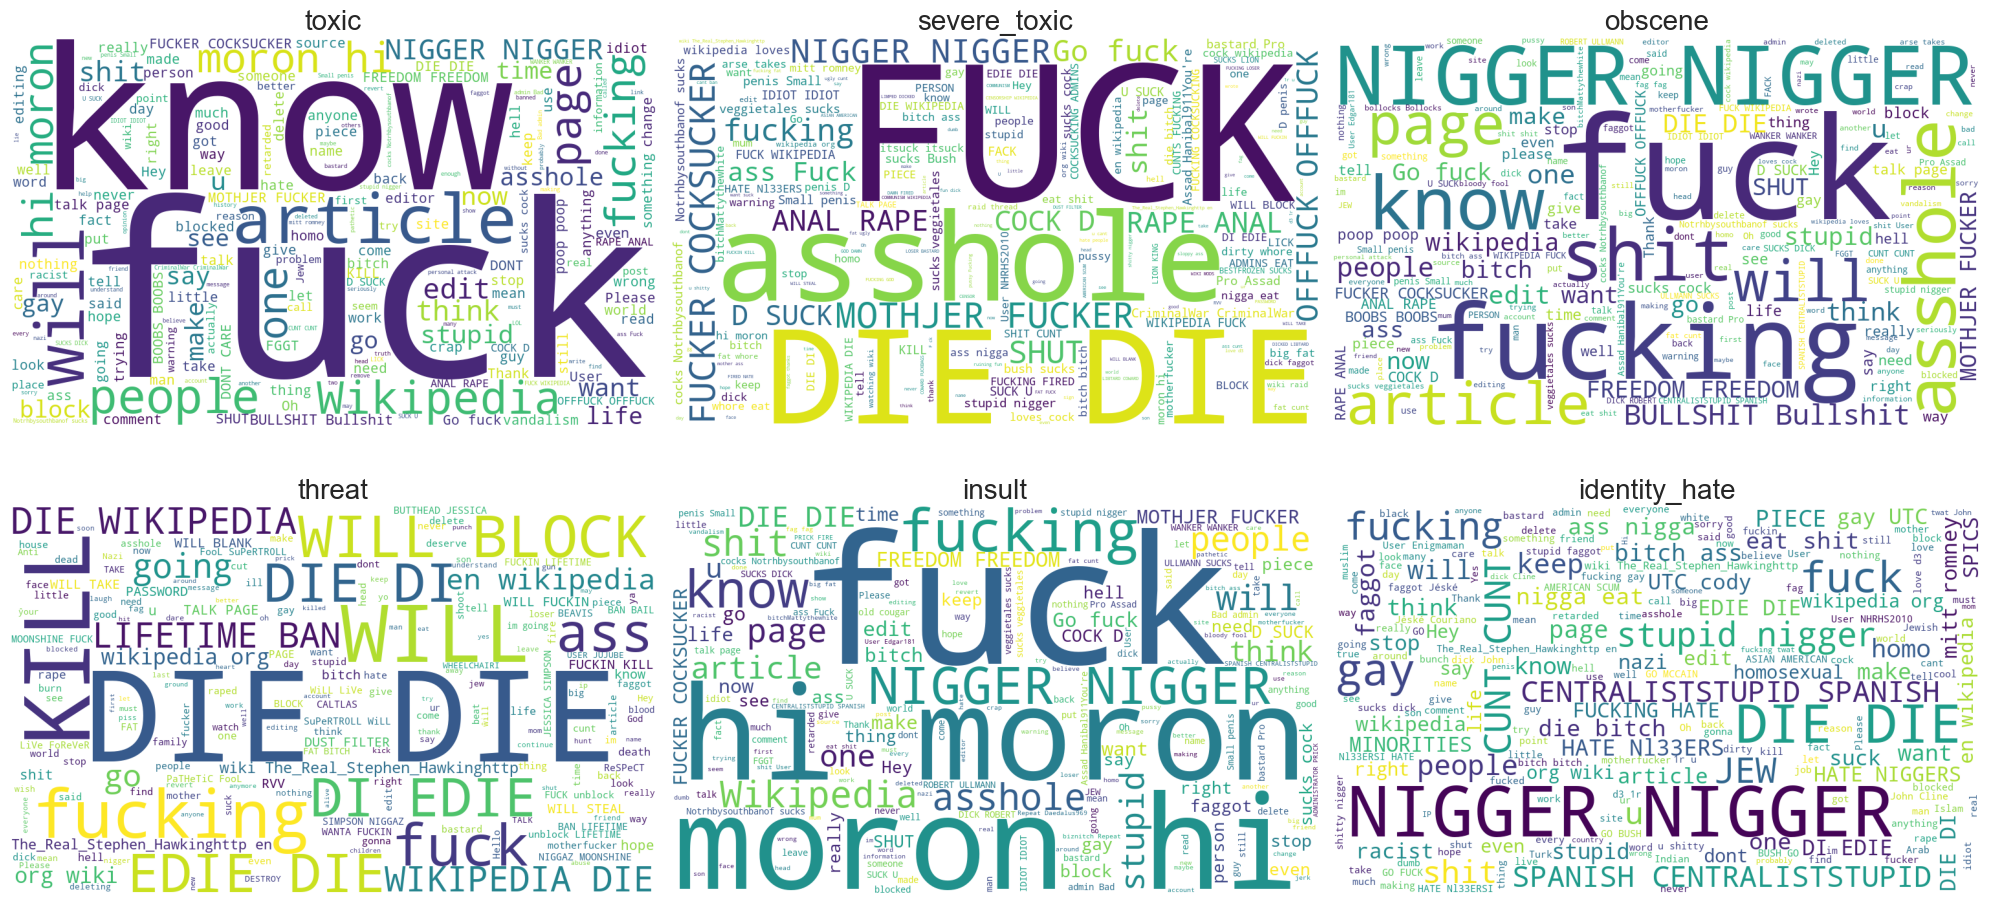

In [22]:
# generate wordclouds for each label in toxic comments
labels = train.columns[2:]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    label = labels[i]
    subset = train[train[label] == 1]
    wordcloud = generate_wordcloud(subset)
    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(label, fontsize=20)
    
plt.tight_layout()
plt.show()

We generated the wordclouds for each toxic label, and we can see that toxic comments usually contain vulgar, profane, and offensive words compared to the non-toxic comments.

### Data Preprocessing and Vectorization

In [23]:
# preprocess the given text
def preprocess(text):
    text = text.lower()
    # remove the punctuation and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    # remove the stopwords
    # because this loop will take a long time, we comment it and use TF-IDF to remove the stopwords
    # words = [w for w in words if w not in stopwords.words('english')]
    lemmatizer = nltk.WordNetLemmatizer()
    # lemmatize the words
    processed_text = [lemmatizer.lemmatize(w) for w in words]
    return processed_text

In [24]:
# get several text samples in train dataset
sample_text = train['comment_text'].iloc[0:3]
sample_text

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
Name: comment_text, dtype: object

In [25]:
# preprocess the text samples
for t in sample_text:
    print(preprocess(t))

['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'weren', 't', 'vandalism', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'doll', 'fac', 'and', 'please', 'don', 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'm', 'retired', 'now']
['d', 'aww', 'he', 'match', 'this', 'background', 'colour', 'i', 'm', 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc']
['hey', 'man', 'i', 'm', 'really', 'not', 'trying', 'to', 'edit', 'war', 'it', 's', 'just', 'that', 'this', 'guy', 'is', 'constantly', 'removing', 'relevant', 'information', 'and', 'talking', 'to', 'me', 'through', 'edits', 'instead', 'of', 'my', 'talk', 'page', 'he', 'seems', 'to', 'care', 'more', 'about', 'the', 'formatting', 'than', 'the', 'actual', 'info']


After preprocessing, we can see that the punctuation and numbers are removed, the stopwords are removed, and the words are lemmatized. We get a list of words for each comment.

In [26]:
# use count vectorizer to vectorize the text samples
count_vectorizer = CountVectorizer(tokenizer=preprocess)
sample = count_vectorizer.fit_transform(sample_text)
sample.todense()

/Users/sage/Documents/Learn/IIT/CS584/Homework/project/CS584_Project_ToxicComment/env4ml/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


matrix([[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
         1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1,
         0, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         0],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
         1, 0, 1, 0, 1, 2, 0, 1, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0]])

This is the result of count vectorizer. This method calculates the frequency of each word in the document. Then it returns a vector of the frequency of each word. 

In [27]:
# use TF-IDF to vectorize the text samples
# tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess)
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess, stop_words='english', min_df=0.001) 
sample = tfidf_vectorizer.fit_transform(sample_text)
sample.todense()

/Users/sage/Documents/Learn/IIT/CS584/Homework/project/CS584_Project_ToxicComment/env4ml/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


matrix([[0.        , 0.        , 0.        , 0.        , 0.19829075,
         0.        , 0.        , 0.        , 0.19829075, 0.19829075,
         0.        , 0.15080523, 0.19829075, 0.19829075, 0.19829075,
         0.        , 0.19829075, 0.        , 0.19829075, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.15080523,
         0.11711371, 0.        , 0.        , 0.19829075, 0.19829075,
         0.15080523, 0.        , 0.        , 0.19829075, 0.        ,
         0.19829075, 0.19829075, 0.        , 0.        , 0.        ,
         0.3965815 , 0.11711371, 0.        , 0.19829075, 0.        ,
         0.        , 0.19829075, 0.        , 0.19829075, 0.19829075,
         0.        , 0.19829075, 0.19829075],
        [0.        , 0.30574243, 0.30574243, 0.        , 0.        ,
         0.30574243, 0.        , 0.30574243, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 

We use TF-IDF to vectorize the text samples. In contrast to count vectorizer, TF-IDF also focus on the frequency of words in the whole document. The words that appear frequently in the whole document will have a lower weight. And the words that appear frequently in a specific document will have a higher weight. So TF-IDF can reduce the weight of common words and increase the weight of rare words. It is more suitable for our model.

In [28]:
# use TF-IDF to vectorize the train dataset
x_train = tfidf_vectorizer.fit_transform(train['comment_text'])
x_train

<159373x3264 sparse matrix of type '<class 'numpy.float64'>'
	with 3168925 stored elements in Compressed Sparse Row format>

In [29]:
# use TF-IDF to vectorize the test dataset
x_test = tfidf_vectorizer.transform(test['comment_text'])
x_test

<153164x3264 sparse matrix of type '<class 'numpy.float64'>'
	with 2670945 stored elements in Compressed Sparse Row format>

In [30]:
print(f"The qty of feature words is: {len(tfidf_vectorizer.get_feature_names_out())}")
tfidf_vectorizer.get_feature_names_out()[:20]

The qty of feature words is: 3264


array(['ability', 'able', 'absence', 'absolute', 'absolutely', 'absurd',
       'abuse', 'abused', 'abusing', 'abusive', 'academic', 'academy',
       'accept', 'acceptable', 'accepted', 'access', 'accident',
       'accordance', 'according', 'accordingly'], dtype=object)

## Basic Model

Compare different models, especially those that perform well in text classification. Therefore, we chose the following basic models for comparison:
* Multinomial Naive Bayes (Multinomial Naive Bayes, MultinomialNB)
* Logistic Regression (LR)
* Linear Support Vector Machine (LinearSVC)

In [31]:
nb_model = MultinomialNB()
log_reg_model = LogisticRegression(max_iter=1000)
svc_model = LinearSVC(dual=False)

from sklearn.model_selection import cross_validate

def cross_validation_score(classifier, X_train, y_train):
    test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    results = []

    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        scores = cross_validate(classifier, X_train, y_train[label], cv=10, 
                                scoring=['recall', 'f1', 'roc_auc'], n_jobs=-1)
        results.append([name, label, 
                        np.mean(scores['test_recall']), 
                        np.mean(scores['test_f1']), 
                        np.mean(scores['test_roc_auc'])])

    return results

# Example usage
methods1_cv = pd.DataFrame(cross_validation_score(nb_model, x_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(log_reg_model, x_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(svc_model, x_train, train))

methods_cv_df = pd.concat([methods1_cv, methods2_cv, methods3_cv]).reset_index(drop=True)
methods_cv_df.columns = ['Model', 'Label', 'Recall', 'F1', 'AUC']
methods_cv_df.round(3)


,Model,Label,Recall,F1,AUC
0,MultinomialNB,toxic,0.495,0.645,0.948
1,MultinomialNB,severe_toxic,0.223,0.320,0.978
2,MultinomialNB,obscene,0.542,0.678,0.963
3,MultinomialNB,threat,0.002,0.004,0.955
4,MultinomialNB,insult,0.455,0.584,0.959
5,MultinomialNB,identity_hate,0.085,0.149,0.960
6,LogisticRegression,toxic,0.608,0.725,0.958
7,LogisticRegression,severe_toxic,0.276,0.369,0.984
8,LogisticRegression,obscene,0.650,0.753,0.975
9,LogisticRegression,threat,0.123,0.203,0.980


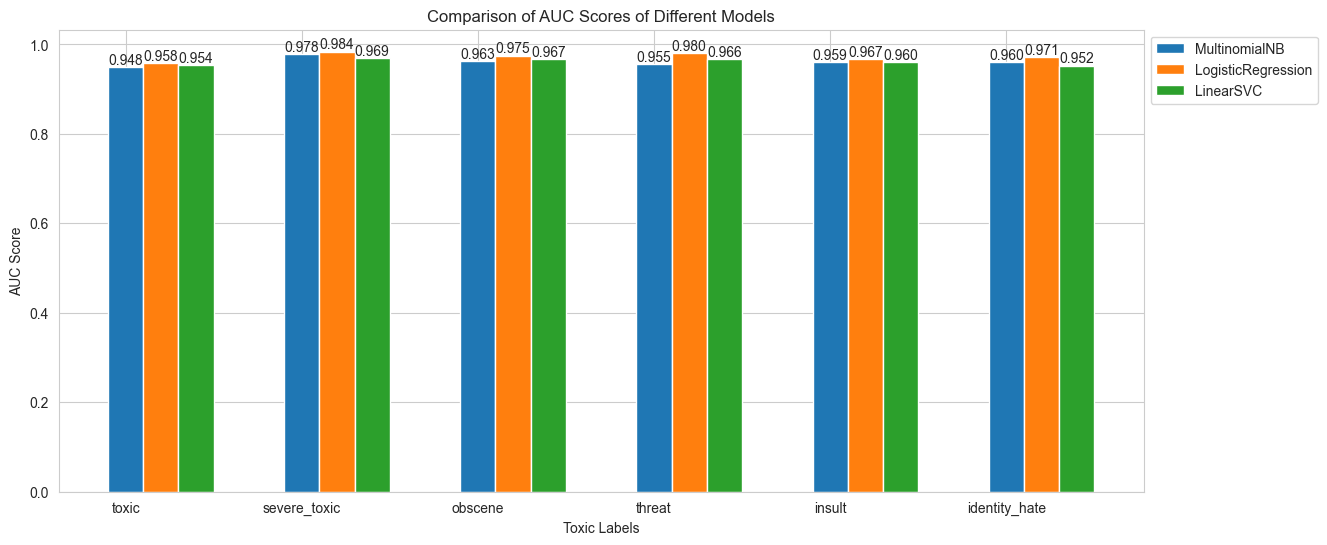

In [38]:
def plot_bar(df):
    plt.figure(figsize=(14, 6))

    # Extract unique labels and models
    labels = df['Label'].unique()
    models = df['Model'].unique()
    num_models = len(models)

    width_bar = 0.2
    x = np.arange(len(labels))  # label locations

    for i, model in enumerate(models, start=1):
        model_data = df[df['Model'] == model]
        bars = plt.bar(x + i*width_bar, model_data['AUC'], width=width_bar, label=model)
        plt.bar_label(bars, fmt='%.3f', label_type='edge')

    plt.xticks(x + width_bar*(num_models-1)/2, labels)
    plt.xlabel("Toxic Labels")
    plt.ylabel("AUC Score")
    plt.title("Comparison of AUC Scores of Different Models")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

# Example usage
plot_bar(methods_cv_df)

- Based on the cross-validation above, we notice the LinearSVC and Logistic Regression models perform better. 
 
- Now we can check how these three models perform on real test datasets.

In [33]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score


def score(classifier, X_train, y_train, X_test, y_test):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
        valid_indices = y_test[label] != -1
        if np.any(valid_indices):
            recall = recall_score(y_test[valid_indices][label], predicted[valid_indices], average="weighted")
            f1 = f1_score(y_test[valid_indices][label], predicted[valid_indices], average="weighted")
            auc = roc_auc_score(y_test[valid_indices][label], predicted[valid_indices], average="weighted")
            conf_mat = confusion_matrix(y_test[valid_indices][label], predicted[valid_indices])
            methods.append([name, label, recall, f1, auc, conf_mat])
        else:
            methods.append([name, label, None, None, None, None])

    return methods

methods1 = pd.DataFrame(score(nb_model, x_train, train, x_test, test_labels))
methods2 = pd.DataFrame(score(log_reg_model, x_train, train, x_test, test_labels))
methods3 = pd.DataFrame(score(svc_model, x_train, train, x_test, test_labels))

methods_df = pd.concat([methods1, methods2, methods3]).reset_index(drop=True)
methods_df.columns = ['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix']
methods_df

,Model,Label,Recall,F1,AUC,ConfusionMatrix
0,MultinomialNB,toxic,0.935165,0.931311,0.760015,"[[56519, 1369], [2779, 3311]]"
1,MultinomialNB,severe_toxic,0.993779,0.993422,0.675846,"[[63450, 161], [237, 130]]"
2,MultinomialNB,obscene,0.964160,0.960633,0.754618,"[[59774, 513], [1780, 1911]]"
3,MultinomialNB,threat,0.996718,0.995095,0.502370,"[[63767, 0], [210, 1]]"
4,MultinomialNB,insult,0.960783,0.956177,0.713494,"[[59973, 578], [1931, 1496]]"
5,MultinomialNB,identity_hate,0.989637,0.985942,0.558018,"[[63232, 34], [629, 83]]"
6,LogisticRegression,toxic,0.931601,0.933541,0.832024,"[[55284, 2604], [1772, 4318]]"
7,LogisticRegression,severe_toxic,0.992748,0.992529,0.653655,"[[63400, 211], [253, 114]]"
8,LogisticRegression,obscene,0.965410,0.964238,0.809457,"[[59428, 859], [1354, 2337]]"
9,LogisticRegression,threat,0.996436,0.995870,0.608511,"[[63704, 63], [165, 46]]"


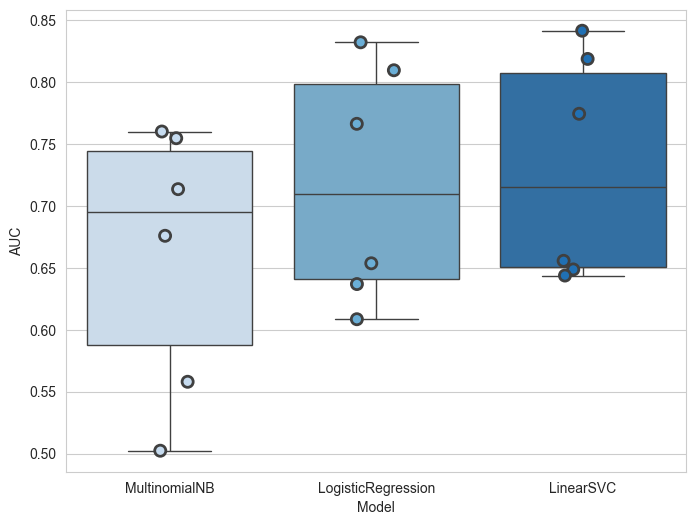

In [34]:
# show AUC scores of different models
plt.figure(figsize=(8, 6))

ax = sns.boxplot(x='Model', y='AUC', data=methods_df, palette="Blues", hue='Model')
sns.stripplot(x='Model', y='AUC', data=methods_df, size=8, jitter=True, 
              linewidth=2, palette="Blues", hue='Model')
plt.show()

In [35]:
methods_df[['AUC','Model']].groupby('Model', as_index=False).mean()

,Model,AUC
0,LinearSVC,0.730400
1,LogisticRegression,0.717793
2,MultinomialNB,0.660727


Based on the AUC scores, LinearSVC performs the best for this task, followed by Logistic Regression and then Multinomial Naive Bayes, which has the lowest performance.

---------- TOXIC Labeling ----------

----- MultinomialNB Model -----


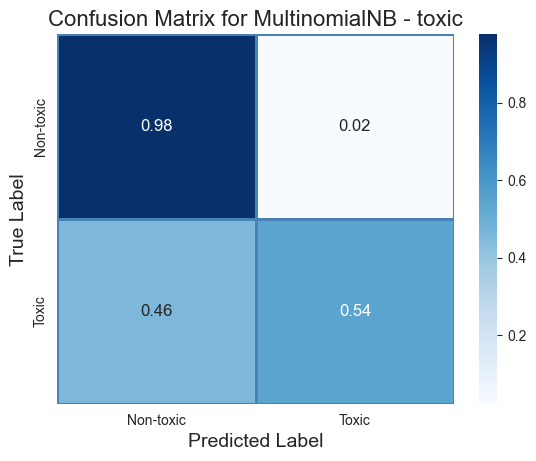


----- LogisticRegression Model -----


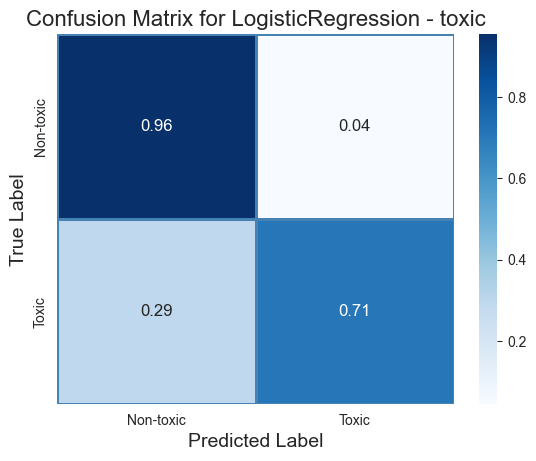


----- LinearSVC Model -----


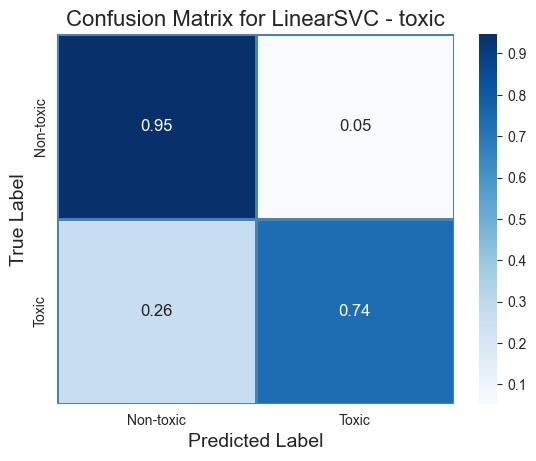

In [51]:
labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

def drawConfusionMatrix(cm, model, label):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12}, cmap="Blues", 
                fmt='.2f', linewidths=2, linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"), yticklabels=("Non-toxic", "Toxic"), ax=ax)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_title(f'Confusion Matrix for {model} - {label}', fontsize=16)
    plt.show()

def Matrix(label):
    print(f"---------- {label.upper()} Labeling ----------")
    pos = labels[label]
    num_labels = len(labels)
    for i in range(pos, len(methods_df), num_labels):
        model = methods_df['Model'][i]
        cm = methods_df['ConfusionMatrix'][i]
        print(f"\n----- {model} Model -----")
        drawConfusionMatrix(cm, model, label)

Matrix('toxic')

## Boosting Model

#### Ensemble Learning part

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]
boosting_list = []
for model in boosting_models:
    boosting_list.append((score(model, x_train, train, x_test, test_labels)))

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Convert each model's score list to DataFrame
ab_df = pd.DataFrame(boosting_list[0], columns=['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix'])
gb_df = pd.DataFrame(boosting_list[1], columns=['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix'])
xgb_df = pd.DataFrame(boosting_list[2], columns=['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix'])
# Combine DataFrames
boosting_df = pd.concat([ab_df, gb_df, xgb_df]).reset_index(drop=True)
boosting_df.columns = ['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix']
boosting_df

In [ ]:
all_methods_df = pd.concat([methods_df, boosting_df]).reset_index(drop=True)

# Function to plot metrics for each model
def plot_metrics(df, metric):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y=metric, hue='Label')
    plt.title(f'{metric} Score by Model and Label')
    plt.ylabel(f'{metric} Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

# Plot Recall, F1, and AUC for each model
plot_metrics(all_methods_df, 'Recall')
plot_metrics(all_methods_df, 'F1')
plot_metrics(all_methods_df, 'AUC')

plt.show()

In [ ]:
boosting_df[['AUC','Model']].groupby('Model', as_index=False).mean()

####  Voting Classifier

In [ ]:
voting_clf = VotingClassifier(estimators=[('ab', ab_clf), ('gb', gb_clf), ('xgb', xgb_clf)], voting='soft')
voting_list = score(voting_clf, x_train, train, x_test, test_labels)
voting_df = pd.DataFrame(voting_list, columns=['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix'])
voting_df

In [ ]:
ensemble_clf = VotingClassifier(estimators=[('lr', log_reg_model),
                                            ('svm', svc_model),
                                            ('xgb', xgb_clf)], voting='hard')

In [ ]:
def score_predict(classifier, x_train, y_train, x_test, test_labels):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    predicted_df =pd.DataFrame()
    predicted_df['id'] = test_labels['id']

    for label in test_labels:
        classifier.fit(x_train, y_train[label])
        predicted = classifier.predict(x_test)
        predicted_df[label] = predicted
        
        recall = recall_score(test_labels[y_test[label] != -1][label], predicted[y_test[label] != -1], average="weighted")
        f1 = f1_score(y_test[test_labels[label] != -1][label], predicted[test_labels[label] != -1], average="weighted")
        auc = roc_auc_score(test_labels[y_test[label] != -1][label], predicted[test_labels[label] != -1], average="weighted")
        conf_mat = confusion_matrix(test_labels[test_labels[label] != -1][label], predicted[test_labels[label] != -1])
        methods.append([name, label, recall, f1, auc, conf_mat])

    return methods, predicted_df

ensemble_score, predicted_df = score_predict(ensemble_clf, x_train, train, x_test, test_labels)
ensemble_score_df = pd.DataFrame(ensemble_score)
ensemble_score_df.columns = ['Model', 'Accuracy', 'Recall', 'F1', 'AUC', 'ConfusionMatrix']
ensemble_score_df

In [ ]:
ensemble_score_df[['AUC','Model']].groupby('Model', as_index=False).mean()